In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import random

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

import pickle
import json
import sys
sys.path.append('..')
import utils

IMAGE_SIZE = 1024
DATASET_PATH = '../mvtec_anomaly_detection_data'

In [2]:
annotations = utils.annotate_dataset(DATASET_PATH)
utils.create_annotation_files(annotations)

Found 15 detection objects.
Detection objects: ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
Annotating: bottle (1/15)
Found 3 classes in ../mvtec_anomaly_detection_data\bottle\ground_truth
Classes: ['broken_large', 'broken_small', 'contamination']
Annotating: cable (2/15)
Found 8 classes in ../mvtec_anomaly_detection_data\cable\ground_truth
Classes: ['bent_wire', 'cable_swap', 'combined', 'cut_inner_insulation', 'cut_outer_insulation', 'missing_cable', 'missing_wire', 'poke_insulation']
Annotating: capsule (3/15)
Found 5 classes in ../mvtec_anomaly_detection_data\capsule\ground_truth
Classes: ['crack', 'faulty_imprint', 'poke', 'scratch', 'squeeze']
Annotating: carpet (4/15)
Found 5 classes in ../mvtec_anomaly_detection_data\carpet\ground_truth
Classes: ['color', 'cut', 'hole', 'metal_contamination', 'thread']
Annotating: grid (5/15)
Found 5 classes in ../mvtec_anomaly_detecti

In [3]:
def inv_dict(d):
    return dict((v, k) for k, v in d.items())

to_load = 'transistor'

object_dict = utils.get_object_dict(DATASET_PATH)
class_dict = utils.get_class_dict(DATASET_PATH, to_load)

anot = inv_dict(object_dict)

dataset = utils.load_annotation_file(f'{anot[to_load]}')
random.shuffle(dataset)
train_ds, test_ds, val_ds = utils.train_test_split_annotations(dataset, 0.6, 0)

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
class MVTEC_Dataset(Dataset):
    def __init__(self, dataset, transforms=None):
        super().__init__()       
        
        self.dataset = dataset
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        data = self.dataset[index]
        
        image = cv2.imread(data[2])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        bbox = list(data[1])
        bbox[0] = bbox[0] * IMAGE_SIZE
        bbox[1] = bbox[1] * IMAGE_SIZE
        bbox[2] = bbox[2] * IMAGE_SIZE + bbox[0]
        bbox[3] = bbox[3] * IMAGE_SIZE + bbox[1]
        bbox = [int(x) for x in bbox]
        area = bbox[2] * bbox[3]
        
        labels = torch.as_tensor([int(data[0])], dtype=torch.int64)
        
        iscrowd = torch.zeros([0], dtype=torch.int64)
        
        target = {}
        target['boxes'] = torch.Tensor([bbox])
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = torch.Tensor([area])
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        else:
            transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()
            ])
            image = transform(image)
        
        return image, target, index
    
    def __len__(self) -> int:
        return len(self.dataset)

In [58]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.RandomRotate90(p=1.0),
        A.RandomRain(),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [59]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [60]:
num_classes = len(class_dict)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [61]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [62]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = MVTEC_Dataset(train_ds, get_train_transform())
test_dataset = MVTEC_Dataset(test_ds, None)
val_dataset = MVTEC_Dataset(val_ds, get_valid_transform())

train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

"""
test_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)
"""

valid_data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=collate_fn
)

In [63]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [64]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1]

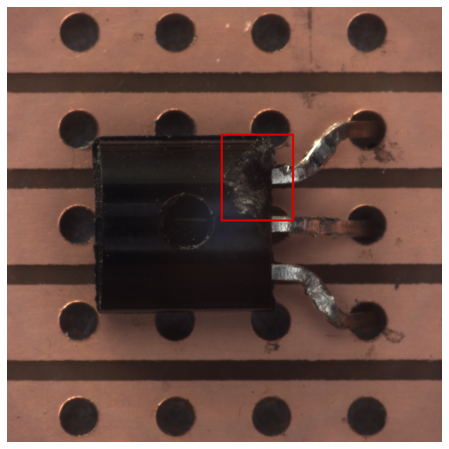

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sample = np.array(torchvision.transforms.ToPILImage()(sample))

for box in boxes:
    cv2.rectangle(sample,
        (box[0], box[1]),
        (box[2], box[3]),
        (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [66]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 100

In [67]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

Epoch #0 loss: 0.4400684154738557
Epoch #1 loss: 0.19696307049277575
Epoch #2 loss: 0.1719037047433681
Epoch #3 loss: 0.15898338068048712
Iteration #50 loss: 0.08623576439203007
Epoch #4 loss: 0.18831703174890055
Epoch #5 loss: 0.17218801742109316
Epoch #6 loss: 0.17539294853907053
Epoch #7 loss: 0.16561880849380523
Iteration #100 loss: 0.2535586183448184
Epoch #8 loss: 0.16559453464054943
Epoch #9 loss: 0.1691463585583195
Epoch #10 loss: 0.17436493999938343
Epoch #11 loss: 0.16221091041547575
Iteration #150 loss: 0.09755650788109799
Epoch #12 loss: 0.16272294190861963
Epoch #13 loss: 0.16521435547864094
Epoch #14 loss: 0.151243375021974
Epoch #15 loss: 0.15747590931576513
Iteration #200 loss: 0.128715206469676
Epoch #16 loss: 0.15324269183125275
Epoch #17 loss: 0.14213075312304466
Epoch #18 loss: 0.12095760084306673
Epoch #19 loss: 0.12262859200970633
Iteration #250 loss: 0.20653276276702814
Epoch #20 loss: 0.13329937401362407
Epoch #21 loss: 0.12885388283205693
Epoch #22 loss: 0.1097

In [104]:
images, targets, image_ids = next(iter(valid_data_loader))

In [105]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [106]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0]

In [107]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [108]:
boxes = [outputs[0]['boxes'][0].detach().numpy().astype(np.int32)]
label = class_dict[outputs[0]['labels'].detach().numpy()[0]]

In [109]:
outputs

[{'boxes': tensor([[464.7298, 721.6950, 560.6420, 888.6893]], grad_fn=<ToCopyBackward0>),
  'labels': tensor([1]),
  'scores': tensor([0.6251], grad_fn=<ToCopyBackward0>)}]

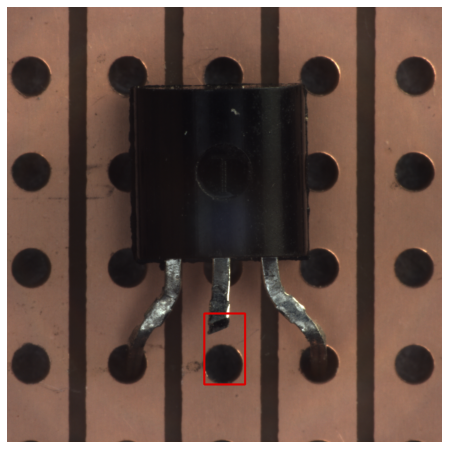

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sample = np.array(torchvision.transforms.ToPILImage()(sample))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [115]:
print(f"Predicted label: {label}")
actual_label = class_dict[targets[0]['labels'].cpu().numpy()[0]]
print(f'Actual label: {actual_label}')

Predicted label: cut_lead
Actual label: cut_lead
